In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [35]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/HSG-Historical-Data.csv', sep=",")
df1=df.reset_index()['Price']

In [36]:
df1 = df1.str.replace(',', '', regex=True).astype(float)

# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [37]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [38]:
print(train_data.shape, test_data.shape)

(919, 1) (394, 1)


In [39]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [40]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
train_last_windowsize = train_data[-time_step-1:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1 ,X_test.shape[1])

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(818, 1, 100)
(818,)
(394, 1, 100)
(394,)


In [43]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,100)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 12s 7ms/step - loss: 0.2052
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0503
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 11/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 12/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 13/100
13/13 [================

In [44]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

13/13 [==============================] - 0s 5ms/step


In [45]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [46]:
# Actual values of the test set
y_test1 = scaler.inverse_transform(ytest.reshape(-1, 1))

# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('RMSE:', test_rmse)

# MAPE
mape_test = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('MAPE:', mape_test)

# MAE
mae_test = np.mean(np.abs(y_test1 - y_pred))
print("MAE:", mae_test)

RMSE: 2151.4571024393313
MAPE: 37.26440878129878
MAE: 2070.021961254759


In [47]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-100:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output_90.extend(yhat.tolist())
        i += 1


0 day input [0.05544331 0.05563411 0.05563411 0.05846221 0.05789503 0.05770683
 0.05808322 0.05525512 0.05186244 0.05035168 0.05261521 0.05487873
 0.05525512 0.05676326 0.05563411 0.0560105  0.0588386  0.05940579
 0.05412335 0.0531824  0.05582231 0.05714226 0.05940579 0.05997036
 0.05978217 0.05902679 0.05940579 0.05902679 0.0616667  0.06072574
 0.06091393 0.06242208 0.06034674 0.05827402 0.05827402 0.06072574
 0.0616667  0.06147851 0.0675137  0.07015361 0.07241714 0.07336071
 0.0707208  0.06807828 0.06902185 0.06807828 0.06770189 0.06789009
 0.06732551 0.06902185 0.07015361 0.0707208  0.06902185 0.06713732
 0.06506199 0.06732551 0.06789009 0.06789009 0.07184995 0.07166176
 0.06506199 0.06430661 0.06487379 0.05940579 0.05940579 0.0552891
 0.04620363 0.05220485 0.06249003 0.0707208  0.07003338 0.06951846
 0.0712331  0.07157812 0.07329014 0.07294773 0.07346265 0.07089069
 0.07140561 0.07534979 0.07723432 0.07260533 0.06951846 0.07020589
 0.07466237 0.07192052 0.0710632  0.07037578 0.0739

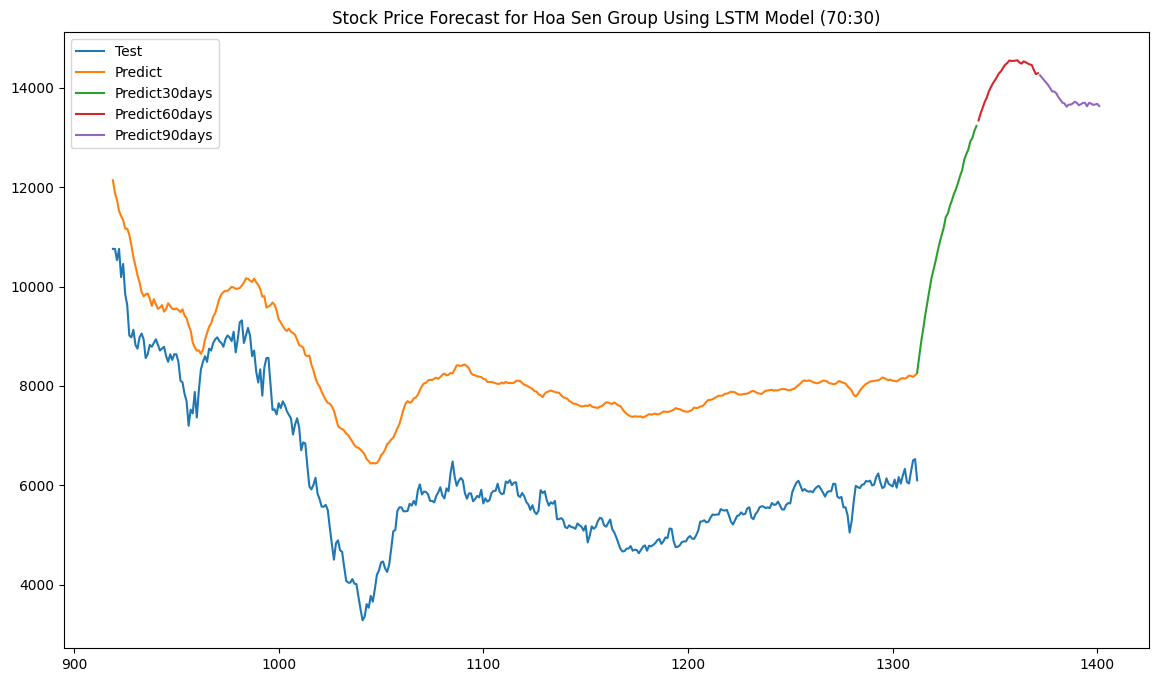

In [48]:
plt.figure(figsize=(14, 8))

# Vẽ dữ liệu kiểm tra (test_data)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
test_pred_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_pred_index, y_pred, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Hoa Sen Group Using LSTM Model (70:30)')
plt.legend(['Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()


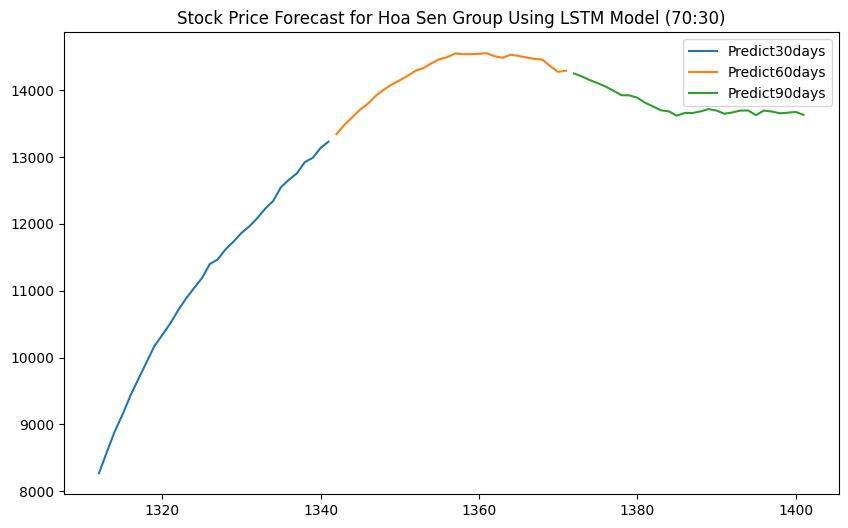

In [49]:
plt.figure(figsize=(10, 6))

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

plt.title('Stock Price Forecast for Hoa Sen Group Using LSTM Model (70:30)')
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()